# Final Project:  Hate Speech Classifier

Matthew Coleman, Nathan Mai, Brandon Shin, and Junyue Wang

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.master('local').getOrCreate()
#sc = SparkContext().getOrCreate()
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
import pickle
from pyspark.sql.functions import col, sum, expr
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Tokenizer, VectorAssembler, StopWordsRemover, NGram, CountVectorizer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC , LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator,  BinaryClassificationEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, NaiveBayesModel
import pyspark.sql.functions as fn
from pyspark.sql.functions import udf
from collections import Counter 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from IPython.display import HTML, display_html, display
from pyspark.mllib.evaluation import BinaryClassificationMetrics,  MulticlassMetrics

In [2]:
tweets_df = pd.read_pickle('/Users/matthewcoleman/Desktop/PSTAT 135/Final project/data/labeled_data.p')
#tweets = pd.read_pickle('labeled_data.p')
#tweets = pd.read_pickle('/Users/nathanmai9/Desktop/PSTAT 135/labeled_data.p')

In [3]:
tweets_full = spark.createDataFrame(tweets_df)

In [4]:
tweets_full.show(5)

+-----+-----------+------------------+-------+-----+--------------------+
|count|hate_speech|offensive_language|neither|class|               tweet|
+-----+-----------+------------------+-------+-----+--------------------+
|    3|          0|                 0|      3|    2|!!! RT @mayasolov...|
|    3|          0|                 3|      0|    1|!!!!! RT @mleew17...|
|    3|          0|                 3|      0|    1|!!!!!!! RT @UrKin...|
|    3|          0|                 2|      1|    1|!!!!!!!!! RT @C_G...|
|    6|          0|                 6|      0|    1|!!!!!!!!!!!!! RT ...|
+-----+-----------+------------------+-------+-----+--------------------+
only showing top 5 rows



Class labels are labeled as follows:
* 0 - hate speech 
* 1 - offensive language 
* 2 - neither

In [5]:
HTML(tweets_full.groupBy(col('class').alias('label')).count().toPandas().to_html(index = False))

label,count
0,1430
1,19190
2,4163


### Data Dimensions

In [6]:
print('There are %d rows and %d columns in the original dataset' % (tweets_full.count(), len(tweets_full.columns)))

There are 24783 rows and 6 columns in the original dataset


### Data Types

In [7]:
tweets_full.dtypes

[('count', 'bigint'),
 ('hate_speech', 'bigint'),
 ('offensive_language', 'bigint'),
 ('neither', 'bigint'),
 ('class', 'bigint'),
 ('tweet', 'string')]

As we can see, all of the values are integers except the tweet itself, which is a string.

### Missingness

In [8]:
tweets_full.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in tweets_full.columns)).show()

+-----+-----------+------------------+-------+-----+-----+
|count|hate_speech|offensive_language|neither|class|tweet|
+-----+-----------+------------------+-------+-----+-----+
|    0|          0|                 0|      0|    0|    0|
+-----+-----------+------------------+-------+-----+-----+



There are no missing values in this dataset, most likely because the data has been curated by the creator.

### Duplicates

In [9]:
tweets_full.count() == tweets_full.dropDuplicates().count()

True

The above code shows us the number of rows in the dataset and the dataset with duplicates dropped are the same, showing there are no duplicates in the dataset.

### Text Processing

In [10]:
tweets = tweets_full.select('tweet', col('class').alias('label'))

In [11]:
#Removing links
tweets = tweets.withColumn('tweet', fn.regexp_replace(col("tweet"), 'http[^"\s]+', ""))

#Removing 'rt', common phrase used to say 'retweet'
#tweets = tweets.withColumn('tweet', fn.regexp_replace(col("tweet"), ' rt ', ""))

#removing user @s
tweets = tweets.withColumn('tweet', fn.regexp_replace(col('tweet'), "@[\w]*", ''))

#removing special characters
tweets = tweets.withColumn('tweet', fn.regexp_replace(col('tweet'), "[^a-zA-Z']", ' '))

#removing extra white spaces
tweets = tweets.withColumn('tweet', fn.regexp_replace(col("tweet"), "\s+", " "))



#tokener
tokenizer = Tokenizer(inputCol = 'tweet',
                     outputCol = 'tokens')
tokenized = tokenizer.transform(tweets)

#removing 'rt', common phrase used to mean 
tokenized = tokenized.withColumn('tokens_nort', expr("filter(tokens, x -> x != 'rt')"))

#removing empty tokens
tokenized_comp = tokenized.withColumn('tokens_nomiss', expr("filter(tokens_nort, x -> x != '')"))




In [12]:
tokenized_comp.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|               tweet|label|              tokens|         tokens_nort|       tokens_nomiss|
+--------------------+-----+--------------------+--------------------+--------------------+
| RT As a woman yo...|    2|[, rt, as, a, wom...|[, as, a, woman, ...|[as, a, woman, yo...|
| RT boy dats cold...|    1|[, rt, boy, dats,...|[, boy, dats, col...|[boy, dats, cold,...|
| RT Dawg RT You e...|    1|[, rt, dawg, rt, ...|[, dawg, you, eve...|[dawg, you, ever,...|
| RT she look like...|    1|[, rt, she, look,...|[, she, look, lik...|[she, look, like,...|
| RT The shit you ...|    1|[, rt, the, shit,...|[, the, shit, you...|[the, shit, you, ...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [13]:
#removing stop words
stop_words = StopWordsRemover.loadDefaultStopWords('english')
stops = StopWordsRemover().setStopWords(stop_words).setInputCol('tokens_nomiss')\
.setOutputCol('tokens_clean')
tweets_nostops = stops.transform(tokenized_comp)

In [14]:
tweets_nostops.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|               tweet|label|              tokens|         tokens_nort|       tokens_nomiss|        tokens_clean|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| RT As a woman yo...|    2|[, rt, as, a, wom...|[, as, a, woman, ...|[as, a, woman, yo...|[woman, complain,...|
| RT boy dats cold...|    1|[, rt, boy, dats,...|[, boy, dats, col...|[boy, dats, cold,...|[boy, dats, cold,...|
| RT Dawg RT You e...|    1|[, rt, dawg, rt, ...|[, dawg, you, eve...|[dawg, you, ever,...|[dawg, ever, fuck...|
| RT she look like...|    1|[, rt, she, look,...|[, she, look, lik...|[she, look, like,...|[look, like, tranny]|
| RT The shit you ...|    1|[, rt, the, shit,...|[, the, shit, you...|[the, shit, you, ...|[shit, hear, migh...|
+--------------------+-----+--------------------+--------------------+--------------------+-----

In [15]:
ngram = NGram(n=2, inputCol="tokens_clean", outputCol="bigrams")
gram_df = ngram.transform(tweets_nostops)

In [16]:
gram_df.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|               tweet|label|              tokens|         tokens_nort|       tokens_nomiss|        tokens_clean|             bigrams|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| RT As a woman yo...|    2|[, rt, as, a, wom...|[, as, a, woman, ...|[as, a, woman, yo...|[woman, complain,...|[woman complain, ...|
| RT boy dats cold...|    1|[, rt, boy, dats,...|[, boy, dats, col...|[boy, dats, cold,...|[boy, dats, cold,...|[boy dats, dats c...|
| RT Dawg RT You e...|    1|[, rt, dawg, rt, ...|[, dawg, you, eve...|[dawg, you, ever,...|[dawg, ever, fuck...|[dawg ever, ever ...|
| RT she look like...|    1|[, rt, she, look,...|[, she, look, lik...|[she, look, like,...|[look, like, tranny]|[look like, like ...|
| RT The shit you ...|    1|[, rt, the, shit,...|[, the, shit,

### Top Word Counts by Label

In [17]:
hate_tweets = gram_df.filter(gram_df.label == 0)
offensive_tweets = gram_df.filter(gram_df.label == 1)
regular_tweets = gram_df.filter(gram_df.label == 2)

In [18]:
def wordcount_pandas(df, inputCol = 'bigrams', outputCol = 'bigrams', top_num = 10):
    from pyspark.sql.functions import explode, desc
    count_df = df.select(explode(
        inputCol).alias(outputCol)).groupBy(outputCol).count().sort(desc("count")).toPandas().iloc[0:top_num]

    return count_df

In [19]:
def wordcount(df, inputCol = 'bigrams', top_num = 10):
    
    #set up the count vectorizer
    count_vec = CountVectorizer().setInputCol(inputCol).setOutputCol('countVec')\
    .setVocabSize(500).setMinTF(1).setMinDF(1)
    count_fit = count_vec.fit(df)
    combined_df = count_fit.transform(df)
    
    #Get the combined dataframe which allows us to see the most common n-grams
    combined_df = (df.select(fn.explode(inputCol).alias('col')).select(
        fn.collect_list('col').alias(inputCol)))
    
    #fit the coutner so we can get the 
    counts = count_fit.transform(combined_df).select('countVec').collect()
    
    count_dict = dict(zip(count_fit.vocabulary, counts[0]['countVec'].values))
    
    dict_counts = Counter(count_dict) 
    top_words = dict_counts.most_common(top_num)  
    
    return top_words

In [20]:
def plot_wordcount(df, inputCol = 'bigrams', outputCol = 'bigrams', top_num = 10, type_tweet = "Hate", color = 'purple'):
    from pyspark.sql.functions import explode, desc
    count_df = df.select(explode(inputCol).alias(outputCol)
                        ).groupBy(outputCol).count().sort(desc("count")).toPandas().iloc[0:top_num]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    count_df.plot.bar(x = outputCol, y = 'count', ax = ax, color = color)
    ax.set_title("Top " + str(top_num) + " Most Frequent " + outputCol.capitalize() + " for " + type_tweet + " Tweets")
    plt.show()

#### Hate Word Counts

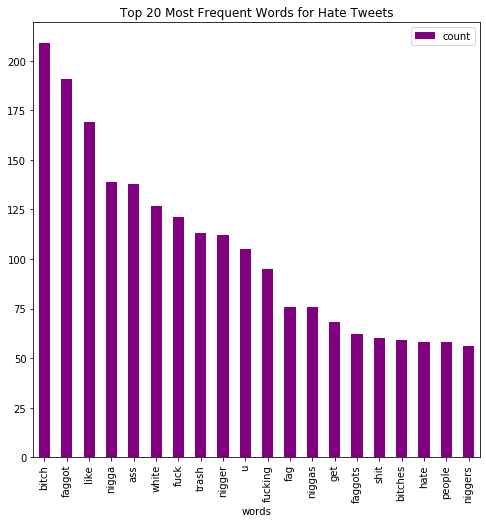

In [21]:
plot_wordcount(hate_tweets,inputCol = 'tokens_clean',
               outputCol = 'words', top_num = 20)

#### Hate Word Counts

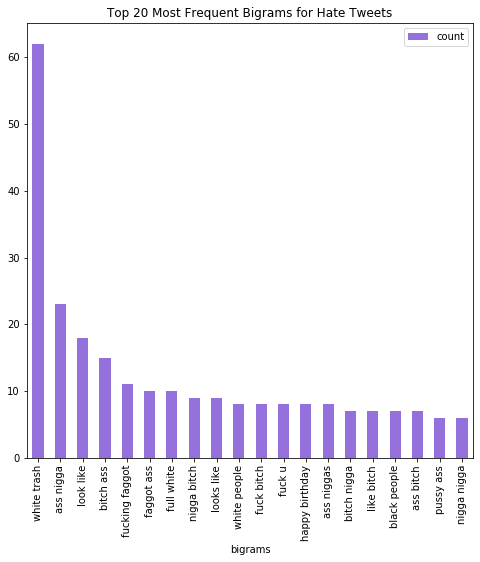

In [22]:
plot_wordcount(hate_tweets ,inputCol = 'bigrams', 
               outputCol = 'bigrams', top_num = 20, color = 'mediumpurple')

#### Offensive Word Counts

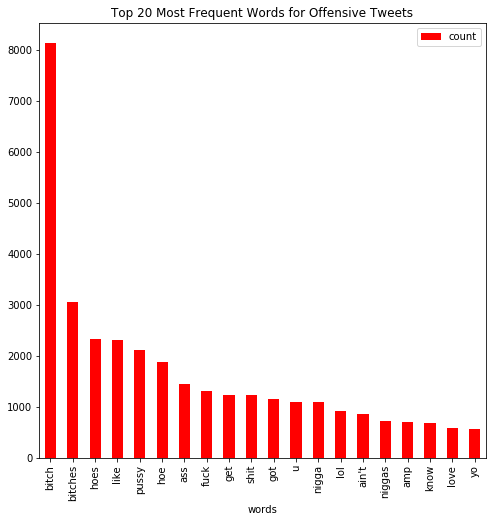

In [23]:
plot_wordcount(offensive_tweets, inputCol = 'tokens_clean',
               outputCol = 'words', top_num = 20, type_tweet= 'Offensive', color = 'red')

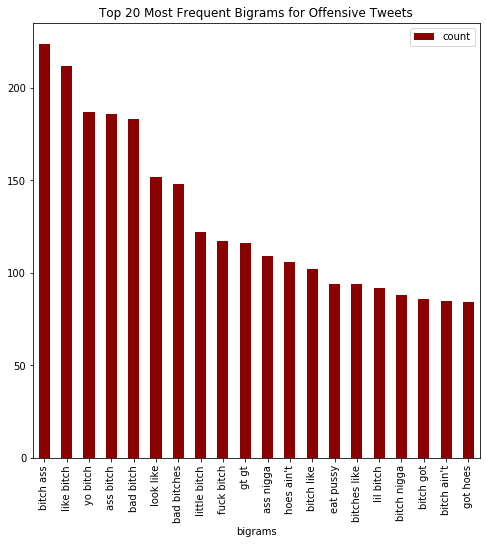

In [24]:
plot_wordcount(offensive_tweets, inputCol = 'bigrams', 
               outputCol = 'bigrams', top_num = 20, type_tweet= 'Offensive', color = 'darkred')

#### Regular Word Counts

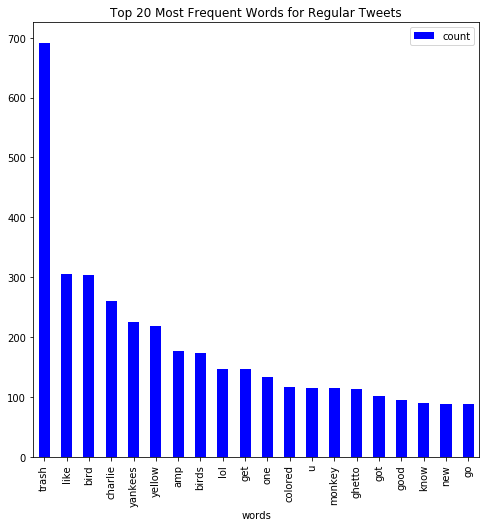

In [25]:
plot_wordcount(regular_tweets, inputCol = 'tokens_clean', 
               outputCol = 'words', top_num = 20, type_tweet = 'Regular', color = 'blue')

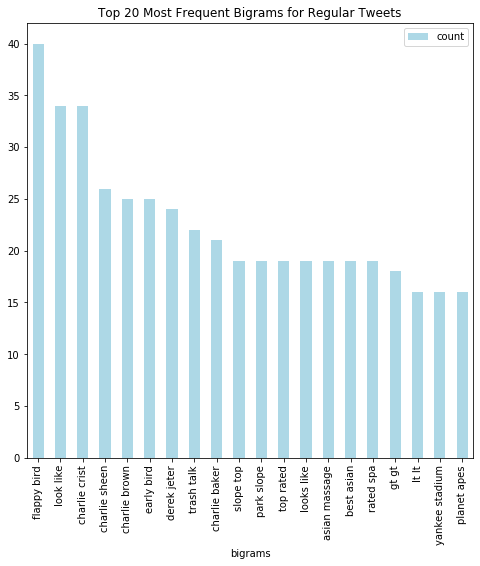

In [26]:
plot_wordcount(regular_tweets, inputCol = 'bigrams', 
               outputCol = 'bigrams', top_num = 20, type_tweet = 'Regular', color = 'lightblue')

##### Wordclouds

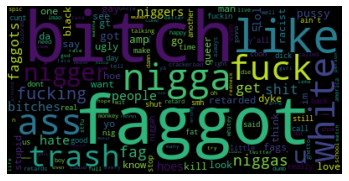

In [27]:
# Hate Speech
from wordcloud import WordCloud
wordcloud = WordCloud().generate_from_frequencies(dict(wordcount(hate_tweets, 
                            inputCol = 'tokens_clean', top_num = 150)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

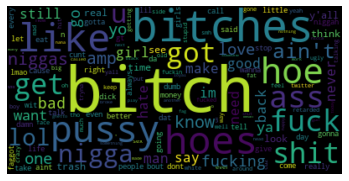

In [28]:
# Offensive Spech
wordcloud = WordCloud().generate_from_frequencies(dict(wordcount(offensive_tweets, 
                            inputCol = 'tokens_clean', top_num = 150)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

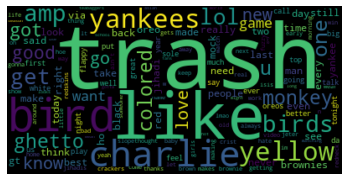

In [29]:
# Regular Tweets
wordcloud = WordCloud().generate_from_frequencies(dict(wordcount(regular_tweets, 
                            inputCol = 'tokens_clean', top_num = 150)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Machine Learning

In [30]:
def print_confusion_matrix(prediction_df):
    conf_mat = prediction_df.stat.crosstab('label','prediction').toPandas().iloc[::-1].reset_index(drop = True)
    
    return HTML(conf_mat.to_html(index = False))

In [31]:
def accuracy_by_label(lr_model):
    lr_sum = lr_model.summary
    
    return HTML(pd.DataFrame(np.array(lr_sum.precisionByLabel).reshape(1,3), 
                             columns = ['Hate', 'Offensive', 'Neither']).to_html(index = False))

In [32]:
def test_accuracy_by_label(prediction_df):
    conf_mat = prediction_df.stat.crosstab('label','prediction').toPandas().iloc[::-1].reset_index(drop = True)
    nums = conf_mat.iloc[:,1:]
    labels = conf_mat.iloc[:,:1]

    diag = np.diag(nums)
    acc = np.array([])
    
    for i in range(0,len(nums.columns)):
        acc = np.append(acc, diag[i]/np.sum(nums.iloc[:,i]))
        
    return HTML(pd.DataFrame(acc.reshape(1,3), columns= ['Hate', 'Offensive', 'Neither']).to_html(index = False))

In [33]:
ml_tweets = gram_df.select(
    col('tokens_clean').alias('tokens'), 
    'bigrams', 'label' )

#Multiclass classification evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")


In [34]:
hashingTF = HashingTF(inputCol="tokens", 
                      outputCol="rawFeatures",
                     numFeatures=10000)
featurizedData = hashingTF.transform(ml_tweets)

idf = IDF(inputCol="rawFeatures", outputCol="features", 
          minDocFreq=50)
idfModel = idf.fit(featurizedData)
rescaled_data = idfModel.transform(featurizedData)

#rescaled_data.select("label", "features").show()

In [35]:
#Train-Test split the data
train, test = rescaled_data.randomSplit([.75,.25], 
                                    seed = 4292020)
#HTML(train.groupBy(col('label')).count().toPandas().to_html(index = False))

In [36]:
#Attempt at weighting the classes in LR. Unsuccessful

#num0 = train.filter(col('label')==0).count()
#num1 = train.filter(col('label')==1).count()
#num2 = train.filter(col('label')==2).count()
#data_size = train.count()
#k = train.select('label').distinct().count()

#weight_0 = data_size/(k*num0)
#weight_1 = data_size/(k*num1)
#weight_2 = data_size/(k*num2)

#train=train.withColumn("classWeights", fn.when(train.label == 0,weight_0).when(train.label == 1,weight_1)\
#                       .otherwise(weight_2))

#train.show(5)
#HTML(train.groupBy(col('label')).count().toPandas().to_html(index = False))

## Logistic Regression Cross-Validation Best Model

Cross-validation code will be commented out because of long run times, but the best parameters will be used to evaluate the final model.

In [37]:
lr = LogisticRegression()
#reg_param = np.linspace(0,1,11)
#Iteration = np.linspace(0,20,5)

#param = ParamGridBuilder().addGrid(lr.regParam, reg_param).addGrid(lr.maxIter,Iteration).addGrid(
#    lr.elasticNetParam,elasticN).build()
#cv = CrossValidator().setEstimator(lr).setEvaluator(evaluator).setEstimatorParamMaps(param).setNumFolds(5)

In [38]:
#best_model = cv.fit(train).bestModel

In [39]:
#best_reg_param = best_model._java_obj.getRegParam()
#best_iter = best_model._java_obj.getMaxIter()

best_reg_param = 0.0
best_iter = 15

print("Best regParam: " + str(best_reg_param))
print("Best MaxIter : " + str(best_iter))

Best regParam: 0.0
Best MaxIter : 15


In [40]:
lr_best = LogisticRegression(maxIter = best_iter,regParam = best_reg_param)
lr_fit_best = lr_best.fit(train)
lr_pred_best = lr_fit_best.transform(train)

print('Confusion Matrix for Training Set Logistic Regression Model: \n')
print_confusion_matrix(lr_pred_best)

Confusion Matrix for Training Set Logistic Regression Model: 



label_prediction,0.0,1.0,2.0
0,376,562,122
1,219,13829,383
2,18,215,2901


In [41]:
print('The accuracy by label for the LR model on the training data')

accuracy_by_label(lr_fit_best)

The accuracy by label for the LR model on the training data


Hate,Offensive,Neither
0.613377,0.946803,0.851732


In [42]:
lr_train_acc = evaluator.evaluate(lr_pred_best)
print('The accuracy for the best Logistic Regression model on the training set is: %f' % lr_train_acc)

The accuracy for the best Logistic Regression model on the training set is: 0.912884


In [43]:
lr_best_pred_test = lr_fit_best.transform(test)
print('Confusion Matrix for Test Set Logistic Regression Model: \n')
print_confusion_matrix(lr_best_pred_test)

Confusion Matrix for Test Set Logistic Regression Model: 



label_prediction,0.0,1.0,2.0
0,104,227,39
1,109,4477,173
2,17,119,893


In [44]:
print('The accuracy by label for the LR model on the test data')
test_accuracy_by_label(lr_best_pred_test)

The accuracy by label for the LR model on the test data


Hate,Offensive,Neither
0.452174,0.92826,0.808145


In [45]:
lr_test_acc = evaluator.evaluate(lr_best_pred_test)
print('The accuracy for the best Logistic Regression model on the training set is: %f' % lr_test_acc)

The accuracy for the best Logistic Regression model on the training set is: 0.882845


In [46]:
lr_fit_best.coefficientMatrix

SparseMatrix(3, 10000, [0, 616, 1232, 1848], [15, 76, 93, 126, 155, 157, 213, 255, ..., 9867, 9874, 9875, 9903, 9936, 9939, 9940, 9949], [0.0623, -0.2898, -0.0559, -0.1917, 0.0725, -0.027, 0.0793, 0.2632, ..., 0.0527, 0.1404, -0.9328, 0.0876, 0.0514, -0.0346, -0.0938, 0.0645], 1)

## Naive Bayes Cross-Validated Best Model

For the cross-validation, the model takes a very long time to run, so we have left the code but saved the best parameters for the model. We will use these parameters in the best model to evaluate this final model.

In [47]:
#nb = NaiveBayes(modelType = 'multinomial')
#smoothparam = np.linspace(1,2,50)
#param = ParamGridBuilder().addGrid(nb.smoothing, smoothparam).build()
#cvbayes = CrossValidator().setEstimator(nb).setEvaluator(evaluator).setEstimatorParamMaps(param).setNumFolds(5)

In [48]:
#bestbayes = cvbayes.fit(train).bestModel
#best_smooth = bestbayes._java_obj.getSmoothing()
best_smooth = 1.0612244897959184
print("Best Smoothing Parameter: \n" + str(best_smooth))

Best Smoothing Parameter: 
1.0612244897959184


#### Best Naive Bayes Model

In [49]:
nb_best = NaiveBayes(modelType = 'multinomial', smoothing = best_smooth)

In [50]:
nb_best_fit = nb_best.fit(train)
nb_train_best = nb_best_fit.transform(train)

In [51]:
#Training
print('Confusion Matrix for Training Set NB model: \n')
print_confusion_matrix(nb_train_best)

Confusion Matrix for Training Set NB model: 



label_prediction,0.0,1.0,2.0
0,467,490,103
1,472,13441,518
2,58,763,2313


In [52]:
print('The accuracy by label for the NB model on the training data')
test_accuracy_by_label(nb_train_best)

The accuracy by label for the NB model on the training data


Hate,Offensive,Neither
0.468405,0.914727,0.788344


In [53]:
#Training
nb_train_acc = evaluator.evaluate(nb_train_best)
print('The accuracy for the best Naive Bayes model on the training set is: %f' % nb_train_acc)

The accuracy for the best Naive Bayes model on the training set is: 0.869271


In [54]:
nb_best_pred = nb_best_fit.transform(test)

In [55]:
print('Confusion Matrix for Test Set NB model: \n')
print_confusion_matrix(nb_best_pred)

Confusion Matrix for Test Set NB model: 



label_prediction,0.0,1.0,2.0
0,124,216,30
1,150,4432,177
2,20,244,765


In [56]:
#test accuracy by label
print('The accuracy by label for the NB model on the test data')
test_accuracy_by_label(nb_best_pred)

The accuracy by label for the NB model on the test data


Hate,Offensive,Neither
0.421769,0.905969,0.787037


In [57]:
nb_best_acc = evaluator.evaluate(nb_best_pred)
print('The accuracy for the best Naive Bayes model on the test set is: %f' % nb_best_acc)

The accuracy for the best Naive Bayes model on the test set is: 0.860004


## Bigram Classifier

CV code included, not run because of long runtimes. Best hyperparameters included.

In [58]:
bi_hashingTF = HashingTF(inputCol="bigrams", 
                      outputCol="rawFeatures",
                     numFeatures=10000)
featurizedData = bi_hashingTF.transform(ml_tweets)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaled_data = idfModel.transform(featurizedData)

#rescaled_data.select("label", "features").show()

In [59]:
#Train-Test split the data
train_bi, test_bi = rescaled_data.randomSplit([.75,.25], 
                                    seed = 4292020)

In [60]:
lr = LogisticRegression()

#reg_param = np.linspace(0,1,1)
#reg_param = np.linspace(0,1,11)
#Iteration = np.linspace(0,20,21)
#elasticN = np.linspace(0,1,5)
#param = ParamGridBuilder().addGrid(lr.regParam, reg_param).addGrid(lr.maxIter,Iteration).addGrid(
#    lr.elasticNetParam,elasticN).build()
#cv = CrossValidator().setEstimator(lr).setEvaluator(evaluator).setEstimatorParamMaps(param).setNumFolds(5)

In [61]:
#best_model_bi = cv.fit(train_bi).bestModel

In [62]:
#best_reg_param_bi = best_model_bi._java_obj.getRegParam()
#best_Iter = best_model._java_obj.getMaxIter()

best_reg_param_bi = 0.0
best_Iter = 15

print("Best regParam: " + str(best_reg_param_bi))
print("Best MaxIter : " + str(best_Iter))

Best regParam: 0.0
Best MaxIter : 15


In [63]:
lr_bi = LogisticRegression(regParam = best_reg_param_bi, maxIter = best_Iter)
lr_fit_bi = lr.fit(train_bi)
lr_bi_pred = lr_fit_bi.transform(train_bi)

In [64]:
print('Confusion Matrix for Training Set LR Bigram model: \n')
print_confusion_matrix(lr_bi_pred) 

Confusion Matrix for Training Set LR Bigram model: 



label_prediction,0.0,1.0,2.0
0,1005,54,1
1,3,14419,9
2,3,49,3082


In [65]:
print('The accuracy by label for the Bigram LR model on the training data')
accuracy_by_label(lr_fit_bi)

The accuracy by label for the Bigram LR model on the training data


Hate,Offensive,Neither
0.994065,0.992907,0.996766


In [66]:
bi_train_acc = evaluator.evaluate(lr_bi_pred)
print('The accuracy for the best Naive Bayes model on the test set is: %f' % bi_train_acc)

The accuracy for the best Naive Bayes model on the test set is: 0.993570


In [67]:
lr_bi_pred_test = lr_fit_bi.transform(test_bi)
print('Confusion Matrix for Test Set LR Bigram model: \n')
print_confusion_matrix(lr_bi_pred_test)

Confusion Matrix for Test Set LR Bigram model: 



label_prediction,0.0,1.0,2.0
0,42,262,66
1,253,3691,815
2,62,615,352


In [68]:
print('The accuracy by label for the Bigram LR model on the test data')
test_accuracy_by_label(lr_bi_pred_test)

The accuracy by label for the Bigram LR model on the test data


Hate,Offensive,Neither
0.117647,0.808012,0.285483


In [69]:
acc_bi = evaluator.evaluate(lr_bi_pred_test)
print('The accuracy for the best Naive Bayes model on the test set is: %f' % acc_bi)

The accuracy for the best Naive Bayes model on the test set is: 0.670606


## Classification with stopwords included

In [70]:
ml_stopwords = tokenized_comp.select(col('tokens_nomiss')\
                                     .alias('tokens'),'label')

In [71]:
stop_hashingTF = HashingTF(inputCol="tokens", 
                      outputCol="rawFeatures",
                     numFeatures=10000)
stoptf = stop_hashingTF.transform(ml_stopwords)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(stoptf)
rescaled_stop = idfModel.transform(stoptf)
#rescaled_stop.select("label", "features").show()

In [72]:
train_stop, test_stop = rescaled_stop.randomSplit([.75,.25], 
                                    seed = 4292020)

In [73]:
lr = LogisticRegression()
#reg_param = np.linspace(0,1,11)
#Iteration = np.linspace(0,20,21)
#elasticN = np.linspace(0,1,5)
#param = ParamGridBuilder().addGrid(lr.regParam, reg_param).addGrid(lr.maxIter,Iteration).addGrid(
#       lr.elasticNetParam,elasticN).build()
#cv = CrossValidator().setEstimator(lr).setEvaluator(evaluator).setEstimatorParamMaps(param).setNumFolds(5)

In [74]:
#best_model_stop= cv.fit(train_stop).bestModel

In [75]:
#best_reg_param_stop = best_model_stop._java_obj.getRegParam()
#best_Iter = best_model._java_obj.getMaxIter()


best_reg_param_stop = 0.0
best_Iter = 15

print("Best regParam: " + str(best_reg_param_stop))
print("Best MaxIter : " + str(best_Iter))

Best regParam: 0.0
Best MaxIter : 15


In [76]:
lr_stop = LogisticRegression(regParam = best_reg_param_stop, maxIter = best_Iter)
lr_fit_stop = lr.fit(train_stop)
lr_stop_pred = lr_fit_stop.transform(train_stop)

print('Confusion Matrix for Training Set LR model with Stopwords Included: \n')
print_confusion_matrix(lr_stop_pred) 

Confusion Matrix for Training Set LR model with Stopwords Included: 



label_prediction,0.0,1.0,2.0
0,1047,29,0
1,32,14371,4
2,0,5,3137


In [77]:
print('The accuracy by label for the Stopword LR model on the training data')

accuracy_by_label(lr_fit_stop)

The accuracy by label for the Stopword LR model on the training data


Hate,Offensive,Neither
0.970343,0.99764,0.998727


In [78]:
stop_train_acc = evaluator.evaluate(lr_stop_pred)
print('The accuracy for the best LR model on the test set is: %f' % stop_train_acc)

The accuracy for the best LR model on the test set is: 0.996244


In [79]:
lr_stop_pred_test = lr_fit_stop.transform(test_stop)
print('Confusion Matrix for Test Set LR model with Stopwords Included: \n')
print_confusion_matrix(lr_stop_pred_test) 

Confusion Matrix for Test Set LR model with Stopwords Included: 



label_prediction,0.0,1.0,2.0
0,90,222,42
1,373,4087,323
2,53,293,675


In [80]:
print('The accuracy by label for the Stopword LR model on the test data')
test_accuracy_by_label(lr_stop_pred_test)

The accuracy by label for the Stopword LR model on the test data


Hate,Offensive,Neither
0.174419,0.888092,0.649038


In [81]:
acc_stop = evaluator.evaluate(lr_stop_pred_test)
print('The accuracy for the best Stopword LR model on the test set is: %f' % acc_stop)

The accuracy for the best Stopword LR model on the test set is: 0.796986


#### Final Models

In [82]:
models = np.array(['Logistic Regression (No Stopwords)','Logistic Regression (Bigrams)', 
                   'Logistic Regression (Stopwords Included)', 'Naive Bayes (No Stopwords)' ])
train_accuracy = np.array([lr_train_acc, bi_train_acc, stop_train_acc, nb_train_acc])
test_accuracy = np.array([lr_test_acc, acc_bi, acc_stop, nb_best_acc])

In [83]:
model_summary = pd.DataFrame({'Models': models, 'Training Accuracy' : train_accuracy, 'Test Accuracy': test_accuracy})
HTML(model_summary.to_html(index = False))

Models,Training Accuracy,Test Accuracy
Logistic Regression (No Stopwords),0.912884,0.882845
Logistic Regression (Bigrams),0.993570,0.670606
Logistic Regression (Stopwords Included),0.996244,0.796986
Naive Bayes (No Stopwords),0.869271,0.860004


# Code Appendix

Logistic Regression

In [84]:
#evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#result = best_model.transform(test).select("label","prediction")
#sumout = evaluator.evaluate(result)
#sumout


In [85]:
#lr = LogisticRegression(regParam = .1)

In [86]:
#lr = LogisticRegression(maxIter = 10, regParam = .1)
#lr_fit = lr.fit(train)
#lr_mod_pred = lr_fit.transform(train)

In [87]:
#model_train = model.transform(train)
#model_train.show()
#lr_mod_pred.stat.crosstab('label','prediction').show()

In [88]:
#lr_mod_pred_test = lr_fit.transform(test)
#lr_mod_pred_test.stat.crosstab('label','prediction').show()

In [89]:
#evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
#evaluator.evaluate(lr_mod_pred_test)

In [90]:
spark.stop()

In [91]:
#!export PATH=/Library/TeX/texbin:$PATH
#jupyter nbconvert your_notebook.ipynb --to pdf